In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from helper import *


## Hyper Parameters

In [2]:
# Set the seed for repeatable results
np.random.seed(25)

# Absolute Trading Costs are 1 basis point
ABS_TCOSTS = 0.0005
# Relative Trading Costs are 10 basis points
REL_TCOSTS = 0.0010

# Set the rebalance frequency
LAGGED_FREQ = 3
REBAL_WINDOW = 120
TOTAL_REBAL_WINDOW = LAGGED_FREQ * REBAL_WINDOW


In [25]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
def compute_rel_drawdown(cumreturns):
    cummax = np.maximum.accumulate(cumreturns)
    drawdown = (cummax-cumreturns)/cummax
    max_rel_drawdown = np.max(drawdown)
    return max_rel_drawdown

In [5]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)
    portfolio = np.dot(X,rweights)

    return portfolio, rweights 

In [6]:
import statsmodels.api as sm

def ols_regression(X, y):
    # Add a constant column to the X matrix
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Return the fitted values
    return results


In [7]:
def ridge_regression(X, y, alpha):
    # Create a Ridge regression model
    model = Ridge(alpha=alpha)

    # Fit the model to the data
    model.fit(X, y)

    # Predict the target variable
    y_pred = model.predict(X)

    return y_pred

In [8]:
def compute_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [9]:
def compute_negative_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    negative_drawdown = np.min(drawdown)
    return negative_drawdown

In [10]:
def implied_t_costs(weights_t, weights_t_1, fixed_t_costs, relative_t_costs):
    """
    weights_t: weights at time t
    weights_t_1: weights at time t-1
    relative_t_costs: relative transaction costs, may be a vector or a scalar
    fixed_t_costs: fixed transaction costs, may be a vector or a scalar
    """
    t_costs = np.sum(fixed_t_costs*np.sign(abs(weights_t-weights_t_1))) + np.sum(relative_t_costs*np.abs(weights_t - weights_t_1))
    return t_costs

### Simple autoencoder

In [11]:
def autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm, hidden_dim):
    # Prepare the data
    l = X_train.shape[1]

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    #print(input_dim)

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis=1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    #print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    #print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    #print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))

    print(X_test.shape)
    print(selected_features)
    selected_X_test = X_test[:, selected_features]
    selected_X_train = X_train[:, selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


### Sparse autoencoder


In [12]:
def sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm, reg):
    # Prepare the data
    l = X_train.shape[1]

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    #print(input_dim)

    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis=1)(input_layer)
    encoder = layers.Dense(input_dim, activation='relu', activity_regularizer=regularizers.l1(reg))(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    #print(X_train.shape)
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train, X_train, epochs=60, batch_size=32, validation_data=(X_test, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test)
    decod_error = abs(decoded_features_test - X_test)

    #print(decod_error.mean(axis=0))
    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    #print(percentage_error)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))

    print(X_test.shape)
    print(selected_features)
    selected_X_test = X_test[:, selected_features]
    selected_X_train = X_train[:, selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)
    print("Number of features in selected X_train:", selected_X_train.shape)
    print("Most communal features:", len(most_comm_indices))
    print("Least communal features:", len(least_comm_indices))

    # Return the de-normalized arrays
    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


### Denoising autoencoder


In [13]:
def denoising_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm, noise, hidden_dim):
    # Prepare the data
    l = X_train.shape[1]

    # Add noise to the input data
    noise_factor = 0.2
    X_train_noisy = X_train + noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    X_test_noisy = X_test + noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

    # Build the autoencoder model
    input_dim = X_train.shape[1]
    input_layer = layers.Input(shape=(input_dim,))
    normalization = layers.BatchNormalization(axis=1)(input_layer)
    encoder = layers.Dense(hidden_dim, activation='relu')(normalization)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')
    history = autoencoder.fit(X_train_noisy, X_train, epochs=30, batch_size=32, validation_data=(X_test_noisy, X_test))

    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test_noisy)
    decod_error = abs(decoded_features_test - X_test)

    mean_values = X_test.mean(axis=0)
    percentage_error = (decod_error.mean(axis=0) / mean_values) * 100
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))

    selected_X_test = X_test[:, selected_features]
    selected_X_train = X_train[:, selected_features]

    return selected_X_test, selected_X_train, Nb_most_comm, Nb_least_comm, history


### Setup dataframe 

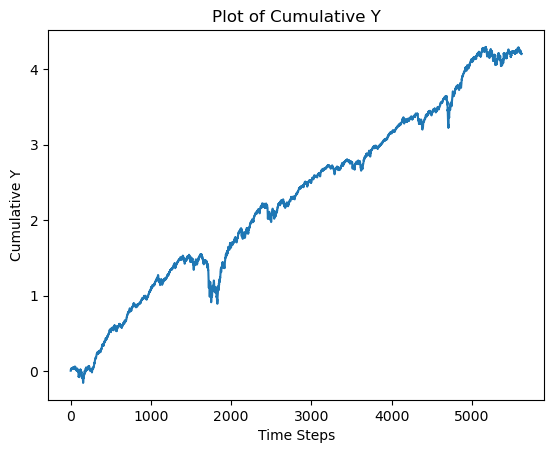

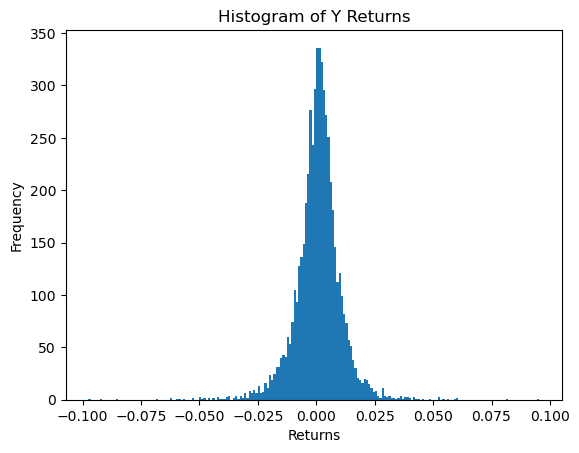

In [14]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]
returns.shape
#X = returns.iloc[:, :-900]
X = returns[returns.columns[-100:]]

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index
cumulative_y = np.cumsum(Y)

plt.plot(cumulative_y)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Y')
plt.title('Plot of Cumulative Y')
plt.show()

plt.hist(Y, bins=200)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Y Returns')
plt.show()

X = X.values

results = pd.DataFrame(index=returns.index)
results["Index - Cumulative"] = index

### Cross validation of the hidden layer dimension(compression level)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
Nb_least_comm = 25
Nb_most_comm = 10
hidden_dim = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
tracking_errors = []
t_costs = []
prev_weights = 0
validation_itr = TimeSeriesSplit(n_splits=len(hidden_dim)).split(X_train, Y_train)

for j, (train_idx, test_idx) in enumerate(validation_itr):

    print(f"Fold {j}:")
    print(f"  Train: index={train_idx}")
    print(f"  Test:  index={test_idx}")

    #X_train_h, Y_train_h = X[(split_index_here - 5 * 28):split_index_here], Y[(split_index_here - 5 * 28):split_index_here]

    Res = autoencoder(X_train[train_idx], X_train[test_idx], Nb_most_comm, Nb_least_comm, hidden_dim[j])
    selected_X_test, selected_X_train, _, _, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train, Y_train[train_idx])
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    tracking_error = np.sqrt(compute_mse(predicted_values, Y_train[test_idx]))
    tracking_errors.append(tracking_error)
    t_costs.append(implied_t_costs(results.params, prev_weights, ABS_TCOSTS, REL_TCOSTS))

best_dim = hidden_dim[np.argmin(tracking_errors)]
total_implied_t_costs = np.sum(t_costs)
print("Implied Transaction Costs:", total_implied_t_costs)
print("Best hidden_dim:", best_dim)
lowest_tracking_error = np.min(tracking_errors)
print("Lowest tracking error:", lowest_tracking_error)

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

### Cross validate regularization for sparse autoencoder 

In [16]:
reg = np.linspace(0.0001, 0.1, 10)
tracking_errors = []
t_costs = []
prev_weights = 0
validation_itr = TimeSeriesSplit(n_splits=len(reg)).split(X_train, Y_train)

for j, (train_idx, test_idx) in enumerate(validation_itr):

    print(f"Fold {j}:")
    print(f"  Train: index={train_idx}")
    print(f"  Test:  index={test_idx}")

    Res = sparse_autoencoder(X_train[train_idx], X_train[test_idx], Nb_most_comm, Nb_least_comm, reg[j])
    selected_X_test, selected_X_train, _, _, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train, Y_train[train_idx])
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    tracking_error = np.sqrt(compute_mse(predicted_values, Y_train[test_idx]))
    tracking_errors.append(tracking_error)
    t_costs.append(implied_t_costs(results.params, prev_weights, ABS_TCOSTS, REL_TCOSTS))

best_reg = reg[np.argmin(tracking_errors)]
total_implied_t_costs = np.sum(t_costs)
print("Implied Transaction Costs:", total_implied_t_costs)
print("Best reg parameter:", best_reg)
lowest_tracking_error = np.min(tracking_errors)
print("Lowest tracking error:", lowest_tracking_error)


Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

### Cross validation of noise in denoising autoencoder 

In [17]:
noise_params = np.linspace(0.1, 1.0, 10)
tracking_errors = []
t_costs = []
prev_weights = 0
validation_itr = TimeSeriesSplit(n_splits=len(noise_params)).split(X_train, Y_train)

for j, (train_idx, test_idx) in enumerate(validation_itr):

    print(f"Fold {j}:")
    print(f"  Train: index={train_idx}")
    print(f"  Test:  index={test_idx}")

    Res = denoising_autoencoder(X_train[train_idx], X_train[test_idx], Nb_most_comm, Nb_least_comm, noise_params[j], best_dim)
    selected_X_test, selected_X_train, _, _, Nb_least_comm_val = Res

    results = ols_regression(selected_X_train, Y_train[train_idx])
    predicted_values = results.predict(sm.add_constant(selected_X_test))
    tracking_error = np.sqrt(compute_mse(predicted_values, Y_train[test_idx]))
    tracking_errors.append(tracking_error)
    t_costs.append(implied_t_costs(results.params, prev_weights, ABS_TCOSTS, REL_TCOSTS))

best_noise_param = noise_params[np.argmin(tracking_errors)]
total_implied_t_costs = np.sum(t_costs)
print("Implied Transaction Costs:", total_implied_t_costs)
print("Best noise parameter:", best_noise_param)
lowest_tracking_error = np.min(tracking_errors)
print("Lowest tracking error:", lowest_tracking_error)


Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

## With rebalancing same rolling window approach as lasso for test/training

## Undercomplete


In [35]:
Y_pred_final_LS = []

Nb_most_comm = 5
Nb_least_com = [10, 20, 30, 40, 50]  # Vector of Nb_least_comm values

Y_pred = pd.DataFrame(index=returns.index, columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)
T_costs = pd.DataFrame(columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)
Drawdowns = pd.DataFrame(columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)

prev_weights = 0

for Nb_least_comm_val in Nb_least_com:
        
    t_costs = []
    relative_drawdowns = []
    Y_pred_final_LS = []
    prev_weights = 0
        
    for i in range(0, X.shape[0]-TOTAL_REBAL_WINDOW, REBAL_WINDOW):
        split_index_here = LAGGED_FREQ*REBAL_WINDOW + i
        print(split_index_here)
        X_train, Y_train = X[(split_index_here - TOTAL_REBAL_WINDOW):split_index_here], Y[(split_index_here - TOTAL_REBAL_WINDOW):split_index_here]

        X_test, Y_test = X[split_index_here:(split_index_here + REBAL_WINDOW)], Y[split_index_here:(split_index_here + REBAL_WINDOW)]
 
        Res = autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm_val, best_dim)
        selected_X_test, selected_X_train, _, _, _ = Res

        results = ols_regression(selected_X_train, Y_train)
        coeff = results.params
        t_costs.append(implied_t_costs(coeff, prev_weights, ABS_TCOSTS, REL_TCOSTS))

        prev_weights = coeff

        predicted_values = results.predict(sm.add_constant(selected_X_test))
        Y_pred_final_LS.extend(predicted_values)
        relative_drawdowns.append(compute_rel_drawdown(np.cumsum(predicted_values)))

    zero_all = np.zeros_like(returns.index.values, dtype=np.float64)
    zero_all[TOTAL_REBAL_WINDOW:] = Y_pred_final_LS
    Y_pred["# Least: " + str(Nb_least_comm_val)] = zero_all
    zero = np.zeros(int(np.ceil((X.shape[0]-TOTAL_REBAL_WINDOW)/REBAL_WINDOW)))
    zero = relative_drawdowns
    Drawdowns["# Least: " + str(Nb_least_comm_val)] = zero
    zero = t_costs
    T_costs["# Least: " + str(Nb_least_comm_val)] = zero

#print("Avg. Implied Transaction Costs per rebalancing period:")
#for Nb_least_comm_val in Nb_least_com:
#    print(f"Nb_least_comm = {Nb_least_comm_val}: {np.average(t_costs[Nb_least_comm_val])}")

#print("Avg. Relative Drawdown per rebalancing period:")
#for Nb_least_comm_val in Nb_least_com:
#   print(f"Nb_least_comm = {Nb_least_comm_val}: {np.average(relative_drawdowns[Nb_least_comm_val])}")
Y_pred_df = Y_pred
Y_pred_df.to_csv('Y_pred.csv')
T_costs_df = T_costs
T_costs_df.to_csv('TCostsAE1.csv')
Drawdowns_df = Drawdowns
Drawdowns_df.to_csv('DrawdownAE1.csv')

360
Epoch 1/30
12/12 [==============================] - 1s 15ms/step - loss: 0.2479 - val_loss: 0.2424
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 0.2241 - val_loss: 0.2334
Epoch 3/30
12/12 [==============================] - 0s 9ms/step - loss: 0.1997 - val_loss: 0.2189
Epoch 4/30
12/12 [==============================] - 0s 8ms/step - loss: 0.1726 - val_loss: 0.1967
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 0.1413 - val_loss: 0.1651
Epoch 6/30
12/12 [==============================] - 0s 8ms/step - loss: 0.1080 - val_loss: 0.1244
Epoch 7/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0757 - val_loss: 0.0806
Epoch 8/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0484 - val_loss: 0.0446
Epoch 9/30
12/12 [==============================] - 0s 9ms/step - loss: 0.0290 - val_loss: 0.0221
Epoch 10/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0172 - val_loss: 0.0109
Epoch 11/30
12

KeyboardInterrupt: 

## Sparse

In [36]:
Y_pred_final_LS = []

Nb_most_comm = 5
Nb_least_com = [10, 20, 30, 40, 50]  # Vector of Nb_least_comm values

Y_pred = pd.DataFrame(index=returns.index, columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)
T_costs = pd.DataFrame(columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)
Drawdowns = pd.DataFrame(columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)

prev_weights = 0

for Nb_least_comm_val in Nb_least_com:
        
    t_costs = []
    relative_drawdowns = []
    Y_pred_final_LS = []
    prev_weights = 0
        
    for i in range(0, X.shape[0]-TOTAL_REBAL_WINDOW, REBAL_WINDOW):
        split_index_here = TOTAL_REBAL_WINDOW + i
        print(split_index_here)
        X_train, Y_train = X[(split_index_here - TOTAL_REBAL_WINDOW):split_index_here], Y[(split_index_here - TOTAL_REBAL_WINDOW):split_index_here]

        X_test, Y_test = X[split_index_here:(split_index_here + REBAL_WINDOW)], Y[split_index_here:(split_index_here + REBAL_WINDOW)]
 
        Res = sparse_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm_val, best_reg)
        selected_X_test, selected_X_train, _, _, _ = Res

        results = ols_regression(selected_X_train, Y_train)
        coeff = results.params
        t_costs.append(implied_t_costs(coeff, prev_weights, ABS_TCOSTS, REL_TCOSTS))

        prev_weights = coeff

        predicted_values = results.predict(sm.add_constant(selected_X_test))
        Y_pred_final_LS.extend(predicted_values)
        relative_drawdowns.append(compute_rel_drawdown(np.cumsum(predicted_values)))

    zero_all = np.zeros_like(returns.index.values, dtype=np.float64)
    zero_all[TOTAL_REBAL_WINDOW:] = Y_pred_final_LS
    Y_pred["# Least: " + str(Nb_least_comm_val)] = zero_all
    zero = np.zeros(int(np.ceil((X.shape[0]-TOTAL_REBAL_WINDOW)/REBAL_WINDOW)))
    zero = relative_drawdowns
    Drawdowns["# Least: " + str(Nb_least_comm_val)] = zero
    zero = t_costs
    T_costs["# Least: " + str(Nb_least_comm_val)] = zero

#print("Avg. Implied Transaction Costs per rebalancing period:")
#for Nb_least_comm_val in Nb_least_com:
#    print(f"Nb_least_comm = {Nb_least_comm_val}: {np.average(t_costs[Nb_least_comm_val])}")

#print("Avg. Relative Drawdown per rebalancing period:")
#for Nb_least_comm_val in Nb_least_com:
#   print(f"Nb_least_comm = {Nb_least_comm_val}: {np.average(relative_drawdowns[Nb_least_comm_val])}")
Y_pred_df = Y_pred
Y_pred_df.to_csv('Y_pred2.csv')
T_costs_df = T_costs
T_costs_df.to_csv('TCostsAE2.csv')
Drawdowns_df = Drawdowns
Drawdowns_df.to_csv('DrawdownAE2.csv')

360
Epoch 1/60
12/12 [==============================] - 1s 16ms/step - loss: 1.6798 - val_loss: 0.2616
Epoch 2/60
12/12 [==============================] - 0s 7ms/step - loss: 1.4007 - val_loss: 0.2478
Epoch 3/60
12/12 [==============================] - 0s 7ms/step - loss: 1.1863 - val_loss: 0.2412
Epoch 4/60
12/12 [==============================] - 0s 8ms/step - loss: 0.9993 - val_loss: 0.2371
Epoch 5/60
12/12 [==============================] - 0s 10ms/step - loss: 0.8332 - val_loss: 0.2341
Epoch 6/60
12/12 [==============================] - 0s 8ms/step - loss: 0.6835 - val_loss: 0.2314
Epoch 7/60
12/12 [==============================] - 0s 9ms/step - loss: 0.5472 - val_loss: 0.2286
Epoch 8/60
12/12 [==============================] - 0s 8ms/step - loss: 0.4401 - val_loss: 0.2257
Epoch 9/60
12/12 [==============================] - 0s 8ms/step - loss: 0.3655 - val_loss: 0.2227
Epoch 10/60
12/12 [==============================] - 0s 8ms/step - loss: 0.3137 - val_loss: 0.2197
Epoch 11/60
1

## Denoising 

In [37]:
Y_pred_final_LS = []

Nb_most_comm = 5
Nb_least_com = [10, 20, 30, 40, 50]  # Vector of Nb_least_comm values

Y_pred = pd.DataFrame(index=returns.index, columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)
T_costs = pd.DataFrame(columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)
Drawdowns = pd.DataFrame(columns=["# Least: " + str(i) for i in Nb_least_com], dtype=np.float64)

prev_weights = 0

for Nb_least_comm_val in Nb_least_com:
        
    t_costs = []
    relative_drawdowns = []
    Y_pred_final_LS = []
    prev_weights = 0
        
    for i in range(0, X.shape[0]-TOTAL_REBAL_WINDOW, REBAL_WINDOW):
        split_index_here = TOTAL_REBAL_WINDOW + i
        print(split_index_here)
        X_train, Y_train = X[(split_index_here - TOTAL_REBAL_WINDOW):split_index_here], Y[(split_index_here - TOTAL_REBAL_WINDOW):split_index_here]

        X_test, Y_test = X[split_index_here:(split_index_here + REBAL_WINDOW)], Y[split_index_here:(split_index_here + REBAL_WINDOW)]
 
        Res = denoising_autoencoder(X_train, X_test, Nb_most_comm, Nb_least_comm_val,best_noise_param, best_dim)
        selected_X_test, selected_X_train, _, _, _ = Res

        results = ols_regression(selected_X_train, Y_train)
        coeff = results.params
        t_costs.append(implied_t_costs(coeff, prev_weights, ABS_TCOSTS, REL_TCOSTS))

        prev_weights = coeff

        predicted_values = results.predict(sm.add_constant(selected_X_test))
        Y_pred_final_LS.extend(predicted_values)
        relative_drawdowns.append(compute_rel_drawdown(np.cumsum(predicted_values)))

    zero_all = np.zeros_like(returns.index.values, dtype=np.float64)
    zero_all[TOTAL_REBAL_WINDOW:] = Y_pred_final_LS
    Y_pred["# Least: " + str(Nb_least_comm_val)] = zero_all
    zero = np.zeros(int(np.ceil((X.shape[0]-TOTAL_REBAL_WINDOW)/REBAL_WINDOW)))
    zero = relative_drawdowns
    Drawdowns["# Least: " + str(Nb_least_comm_val)] = zero
    zero = t_costs
    T_costs["# Least: " + str(Nb_least_comm_val)] = zero

#print("Avg. Implied Transaction Costs per rebalancing period:")
#for Nb_least_comm_val in Nb_least_com:
#    print(f"Nb_least_comm = {Nb_least_comm_val}: {np.average(t_costs[Nb_least_comm_val])}")

#print("Avg. Relative Drawdown per rebalancing period:")
#for Nb_least_comm_val in Nb_least_com:
#   print(f"Nb_least_comm = {Nb_least_comm_val}: {np.average(relative_drawdowns[Nb_least_comm_val])}")
Y_pred_df = Y_pred
Y_pred_df.to_csv('Y_pred3.csv')
T_costs_df = T_costs
T_costs_df.to_csv('TCostsAE3.csv')
Drawdowns_df = Drawdowns
Drawdowns_df.to_csv('DrawdownAE3.csv')

360
Epoch 1/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2564 - val_loss: 0.2341
Epoch 2/30
12/12 [==============================] - 0s 7ms/step - loss: 0.2231 - val_loss: 0.2135
Epoch 3/30
12/12 [==============================] - 0s 8ms/step - loss: 0.1930 - val_loss: 0.1914
Epoch 4/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1642 - val_loss: 0.1671
Epoch 5/30
12/12 [==============================] - 0s 8ms/step - loss: 0.1354 - val_loss: 0.1411
Epoch 6/30
12/12 [==============================] - 0s 7ms/step - loss: 0.1081 - val_loss: 0.1147
Epoch 7/30
12/12 [==============================] - 0s 7ms/step - loss: 0.0834 - val_loss: 0.0896
Epoch 8/30
12/12 [==============================] - 0s 7ms/step - loss: 0.0623 - val_loss: 0.0677
Epoch 9/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0455 - val_loss: 0.0499
Epoch 10/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0330 - val_loss: 0.0363
Epoch 11/30
12

# Plotting

Text(0.5, 1.0, 'Plot of Cumulative Returns')

<Figure size 1000x500 with 0 Axes>

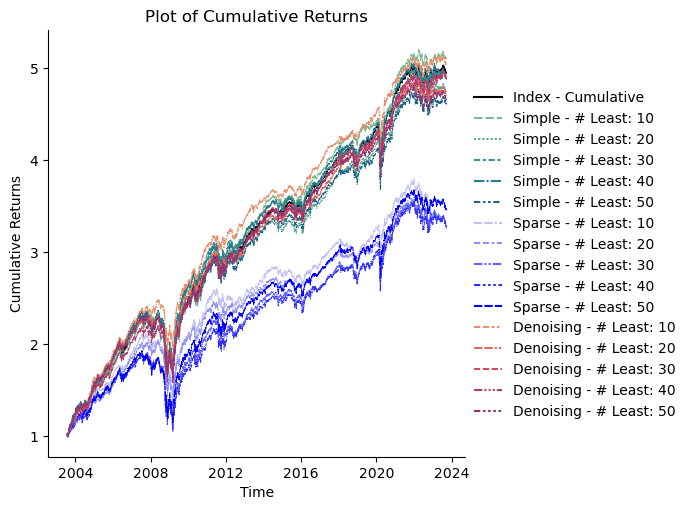

In [59]:
import warnings
warnings.filterwarnings('ignore')

tracking_errors = []
results = pd.DataFrame(index=returns.index)
zero = np.zeros_like(returns.index.values, dtype=np.float64)
zero[TOTAL_REBAL_WINDOW:] = 1 + np.cumsum(index[TOTAL_REBAL_WINDOW:])
results["Index - Cumulative"] = zero

palette_index = ["Black"]
palette_simple = sns.color_palette('crest')[:5] 
palette_sparse = sns.color_palette('light:b')[1:6]
palette_denoising = sns.color_palette('flare')[:5]

for file, name in zip(['Y_pred.csv', 'Y_pred2.csv', 'Y_pred3.csv'],['Simple', 'Sparse', 'Denoising']):
    Y_pred = pd.read_csv(file, index_col=0, header=0)
    nb_array = [10, 20, 30, 40, 50]
    columns_res = [name + " - # Least: " + str(nb) for nb in nb_array]
    columns_pred = ["# Least: " + str(nb) for nb in nb_array]
    for i, column in enumerate(columns_res):
        results[column] = 1 + np.cumsum(Y_pred[columns_pred[i]].values)

# Plot all methods
plt.figure(figsize=(10, 5))
sns.relplot(data=results[results.columns][TOTAL_REBAL_WINDOW:], kind='line', palette=palette_index + palette_simple + palette_sparse + palette_denoising, linewidth=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Plot of Cumulative Returns')

## Plotting Simple Autoencoder

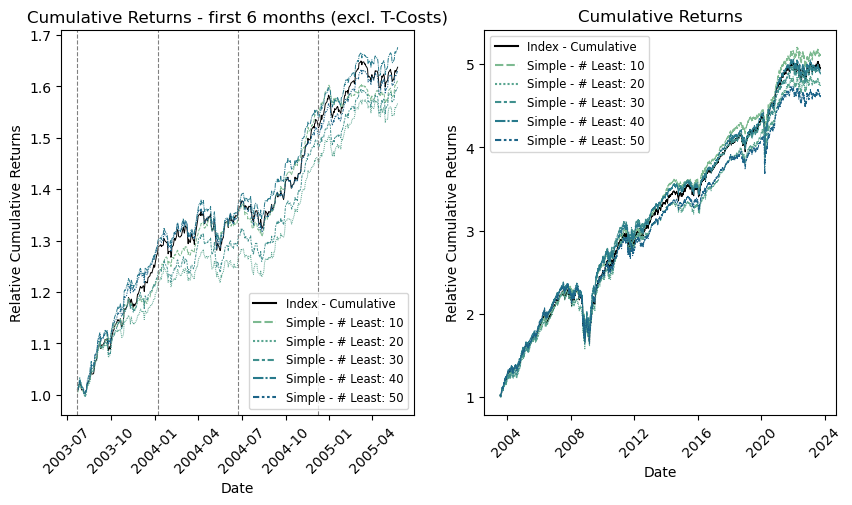

In [76]:
plt.figure(figsize=(10, 5))
features = ['Index - Cumulative', 'Simple - # Least: 10', 'Simple - # Least: 20',  'Simple - # Least: 30', 'Simple - # Least: 40', 'Simple - # Least: 50']

plt.subplot(1, 2, 1)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:2*TOTAL_REBAL_WINDOW+REBAL_WINDOW], palette=palette_index + palette_simple, linewidth=0.7)
for i in range(TOTAL_REBAL_WINDOW, 2*TOTAL_REBAL_WINDOW + REBAL_WINDOW, REBAL_WINDOW):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

plt.subplot(1, 2, 2)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:], palette=palette_index + palette_simple, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns (excl. T-Costs)')
plt.title('Cumulative Returns')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

## Plotting Sparse Autoencoder

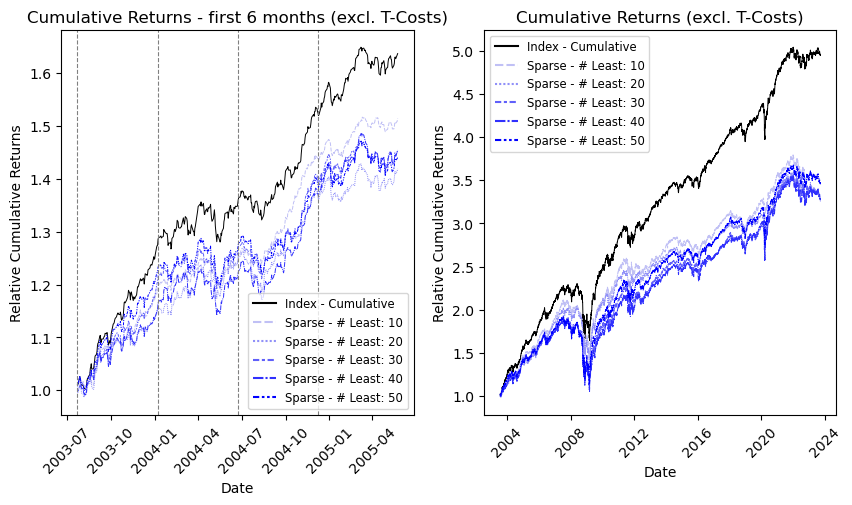

In [79]:
plt.figure(figsize=(10, 5))
typ = "Sparse"
features = ['Index - Cumulative'] + [typ + " - # Least: " + str(i) for i in [10,20,30,40,50]]

plt.subplot(1, 2, 1)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:2*TOTAL_REBAL_WINDOW+REBAL_WINDOW], palette=palette_index + palette_sparse, linewidth=0.7)
for i in range(TOTAL_REBAL_WINDOW, 2*TOTAL_REBAL_WINDOW + REBAL_WINDOW, REBAL_WINDOW):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

plt.subplot(1, 2, 2)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:], palette=palette_index + palette_sparse, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

## Plotting Denoising Autoencoder

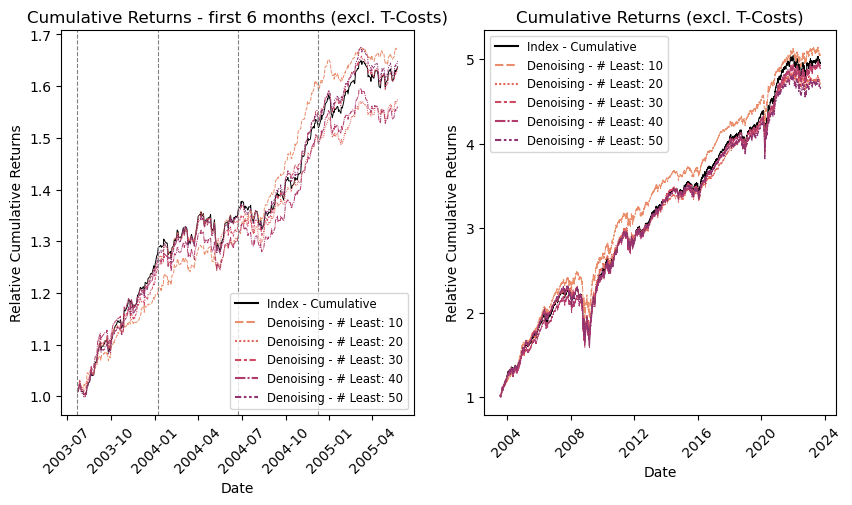

In [78]:
plt.figure(figsize=(10, 5))
typ = "Denoising"
features = ['Index - Cumulative'] + [typ + " - # Least: " + str(i) for i in [10,20,30,40,50]]

plt.subplot(1, 2, 1)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:2*TOTAL_REBAL_WINDOW+REBAL_WINDOW], palette=palette_index + palette_denoising, linewidth=0.7)
for i in range(TOTAL_REBAL_WINDOW, 2*TOTAL_REBAL_WINDOW + REBAL_WINDOW, REBAL_WINDOW):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

plt.subplot(1, 2, 2)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:], palette=palette_index + palette_denoising, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

## Compute metrics

## Mean squared error

In [64]:
tracking_errors = np.zeros((3, 5))
rebalance = 60
split_index = rebalance*5
j = 0
for file, name in zip(['Y_pred.csv', 'Y_pred2.csv', 'Y_pred3.csv'], ['Simple', 'Sparse', 'Denoising']):
    Y_pred = pd.read_csv(file, index_col=0, header=0)
    nb_array = [10, 20, 30, 40, 50]
    columns_res = ["# Least: " + str(nb) for nb in nb_array]
    for i, column in enumerate(columns_res):
        tracking_errors[j][i] = np.std(np.cumsum(Y_pred[column][TOTAL_REBAL_WINDOW:]).values - np.cumsum(Y)[TOTAL_REBAL_WINDOW:])
    j = j + 1       

tracking_errors_df = pd.DataFrame(tracking_errors, columns=columns_res, index=['Simple', 'Sparse', 'Denoising'])
tracking_errors_df.to_csv('tracking_errors.csv', index=False)
tracking_errors_df

# Least: 10  # Least: 20  # Least: 30  # Least: 40  # Least: 50
Simple        0.061896     0.070920     0.068745     0.035957     0.118181
Sparse        0.416534     0.454620     0.453319     0.453020     0.399026
Denoising     0.077577     0.073977     0.043980     0.026589     0.081183

## T_Costs(here only for simple AE and sparse AE)

In [70]:
total_sum_df = pd.DataFrame(columns=['Simple AE', 'Sparse AE', 'Denoising AE'], index=["# Least: " + str(nb) for nb in [10, 20, 30, 40, 50]])
for file, name in zip(['TCostsAE1.csv', 'TCostsAE2.csv', 'TCostsAE3.csv'], ['Simple AE', 'Sparse AE', 'Denoising AE']):
    T_costs_df = pd.read_csv(file, index_col=0, header=0)
    total_sum = T_costs_df.sum(axis=0)
    total_sum_df[name] = total_sum.values

display(total_sum_df)

Simple AE  Sparse AE  Denoising AE
# Least: 10   0.374435   0.374351      0.375133
# Least: 20   0.597303   0.598866      0.596949
# Least: 30   0.817726   0.820175      0.819637
# Least: 40   1.038168   1.040561      1.039811
# Least: 50   1.259181   1.261164      1.260566

## Drawdowns


In [9]:
Drawdowns_df = pd.DataFrame(columns=['Simple AE', 'Sparse AE', 'Denoising AE'], index=["# Least: " + str(nb) for nb in [10, 20, 30, 40, 50]])
for file, name in zip(['Y_pred.csv', 'Y_pred2.csv', 'Y_pred3.csv'], ['Simple AE', 'Sparse AE', 'Denoising AE']):
    drawdown_df = pd.read_csv(file, index_col=0, header=0)
    max_drawdown = drawdown_df[TOTAL_REBAL_WINDOW:].cumsum(axis=0).apply(compute_rel_drawdown, axis=0)
    Drawdowns_df[name] = max_drawdown

display(Drawdowns_df)


Simple AE  Sparse AE  Denoising AE
# Least: 10   1.062089   0.728466      0.379735
# Least: 20   0.951157   1.697477      0.621112
# Least: 30   1.141753   4.654329      0.923161
# Least: 40   0.859494   1.396487      1.034617
# Least: 50   0.962166   1.037279      1.068316

## Best Methods based on Tracking Error

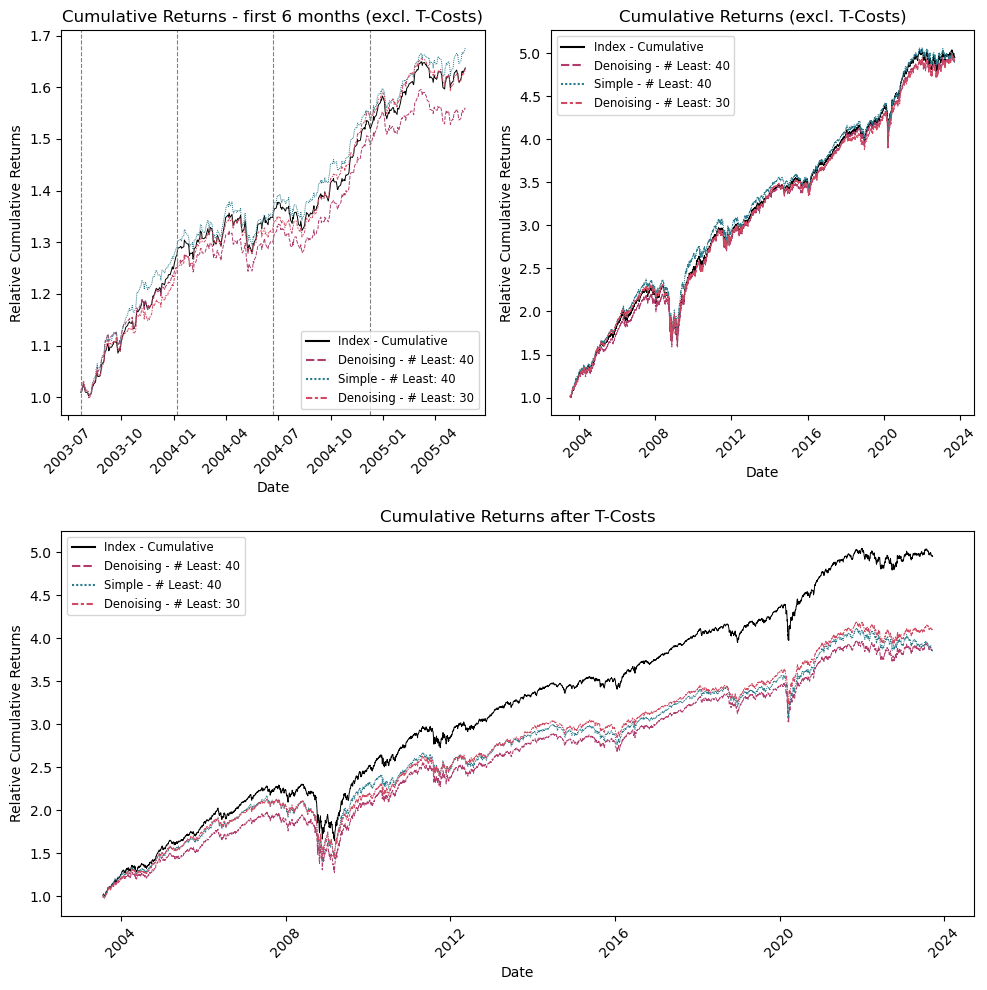

In [106]:
### Three lowest tracking errors: 1. Denoising Least 40, 2. Simple Least 40 3. Denoising Least 30

features = ['Index - Cumulative', 'Denoising - # Least: 40', 'Simple - # Least: 40', 'Denoising - # Least: 30']
palette = palette_index + [palette_denoising[3], palette_simple[3], palette_denoising[2]]

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:2*TOTAL_REBAL_WINDOW+REBAL_WINDOW], palette=palette, linewidth=0.7)
for i in range(TOTAL_REBAL_WINDOW, 2*TOTAL_REBAL_WINDOW + REBAL_WINDOW, REBAL_WINDOW):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

plt.subplot(2, 2, 2)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

plt.subplot(2, 2, (3,4))
t_costs_rebal = pd.DataFrame(columns=features)
T_costs_df_denoising = pd.read_csv('TCostsAE3.csv', index_col=0, header=0)
t_costs_rebal[['Denoising - # Least: 40', 'Denoising - # Least: 30']] = T_costs_df_denoising[['# Least: 40', '# Least: 30']]
T_costs_df_simple = pd.read_csv('TCostsAE1.csv', index_col=0, header=0)
t_costs_rebal['Simple - # Least: 40'] = T_costs_df_simple['# Least: 40']
t_costs_rebal['Index - Cumulative'] = 0

t_costs_sum = t_costs_rebal.cumsum(axis=0)

tc = pd.DataFrame(columns=features, index=returns.index)
for i, j in zip(np.arange(TOTAL_REBAL_WINDOW, len(returns.index), REBAL_WINDOW), t_costs_sum.index.values):
    tc.loc[tc.index.values[i]] = t_costs_sum.loc[t_costs_sum.index.values[j]]

tc.fillna(method='ffill', inplace=True)
tc.fillna(0, inplace=True)

sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:]-tc[features][TOTAL_REBAL_WINDOW:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns after T-Costs')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

plt.tight_layout()
plt.show()

## Best Features Based on T-Costs

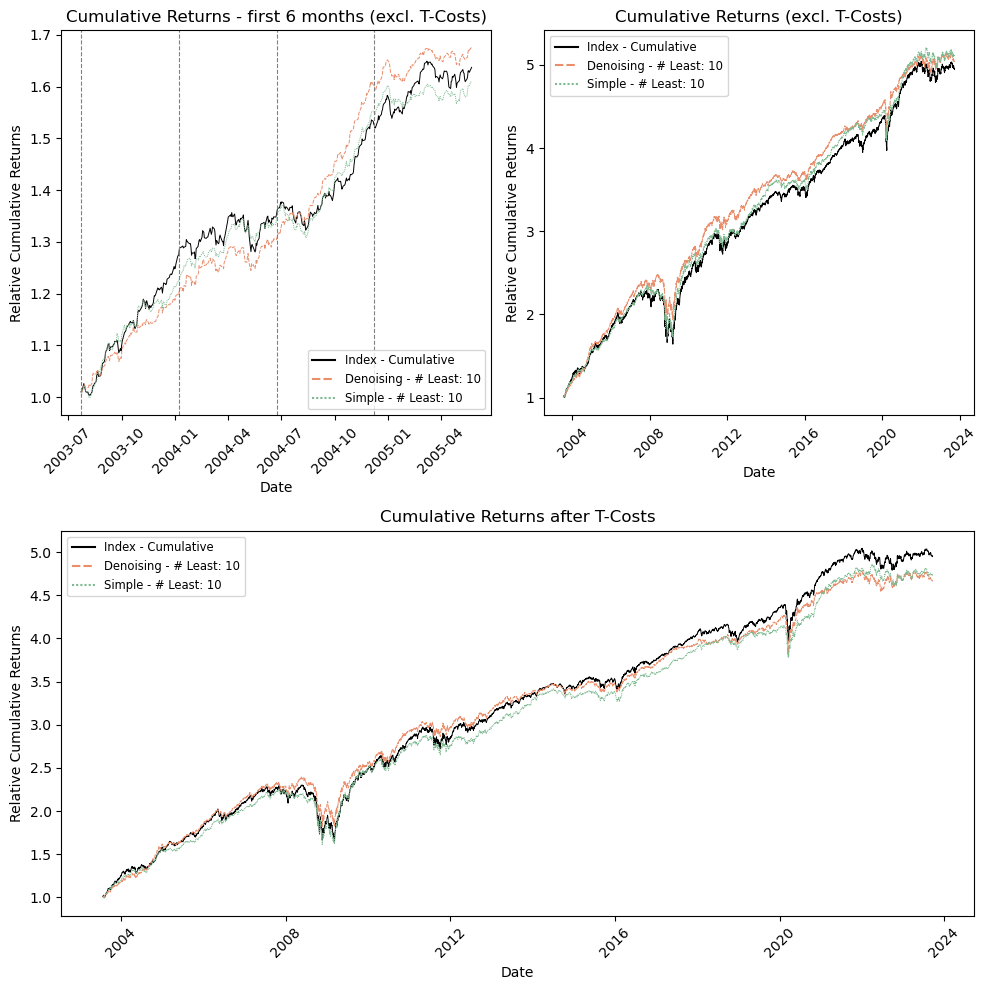

In [107]:
features = ['Index - Cumulative', 'Denoising - # Least: 10', 'Simple - # Least: 10']
palette = palette_index + [palette_denoising[0], palette_simple[0]]

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:2*TOTAL_REBAL_WINDOW+REBAL_WINDOW], palette=palette, linewidth=0.7)
for i in range(TOTAL_REBAL_WINDOW, 2*TOTAL_REBAL_WINDOW + REBAL_WINDOW, REBAL_WINDOW):
    plt.axvline(results.index.values[i], color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns - first 6 months (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize='small')

plt.subplot(2, 2, 2)
sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns (excl. T-Costs)')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

plt.subplot(2, 2, (3,4))
t_costs_rebal['Index - Cumulative'] = 0

t_costs_sum = t_costs_rebal.cumsum(axis=0)

tc = pd.DataFrame(columns=features, index=returns.index)
for i, j in zip(np.arange(TOTAL_REBAL_WINDOW, len(returns.index), REBAL_WINDOW), t_costs_sum.index.values):
    tc.loc[tc.index.values[i]] = t_costs_sum.loc[t_costs_sum.index.values[j]]

tc.fillna(method='ffill', inplace=True)
tc.fillna(0, inplace=True)

sns.lineplot(data=results[features][TOTAL_REBAL_WINDOW:]-tc[features][TOTAL_REBAL_WINDOW:], palette=palette, linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Relative Cumulative Returns')
plt.title('Cumulative Returns after T-Costs')
plt.xticks(rotation=45)
plt.legend(fontsize='small')

plt.tight_layout()
plt.show()

## Distribution of tracking errors

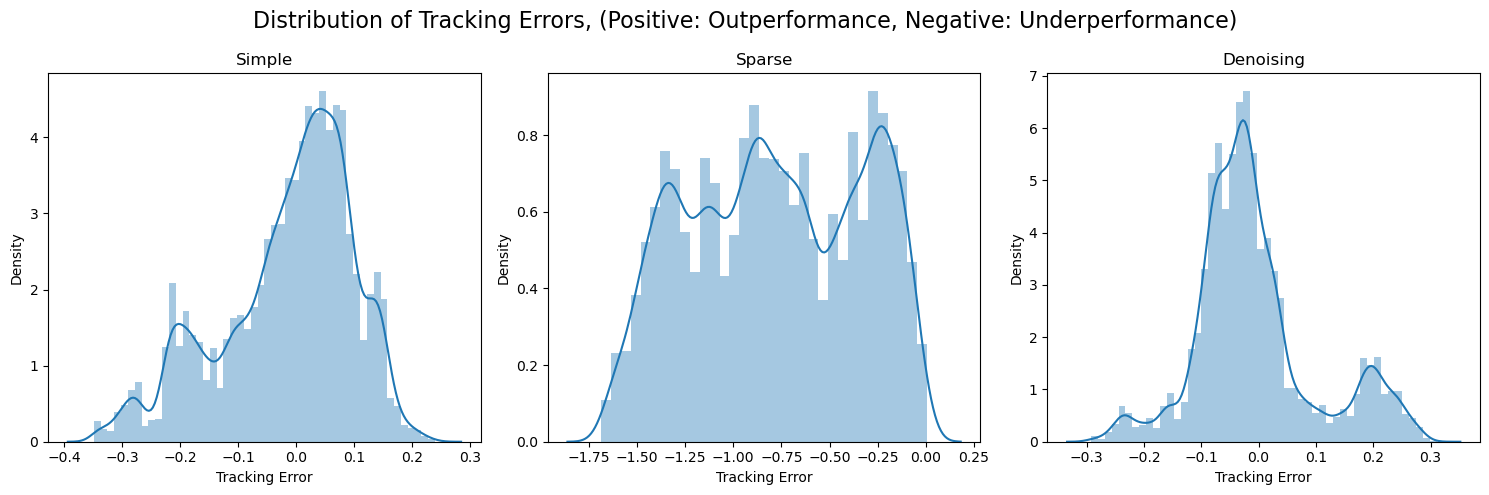

In [133]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout(pad=3.0)
for j in range(3):
    name = ['Simple', 'Sparse', 'Denoising'][j]
    data = results[[name + " - # Least: " + str(nb) for nb in [10,20,30,40,50]]].values - np.tile(results["Index - Cumulative"].values, (5,1)).T
    sns.distplot(data[TOTAL_REBAL_WINDOW:], ax=axs[j])
    axs[j].set_title(name)
    axs[j].set_xlabel('Tracking Error')

fig.suptitle('Distribution of Tracking Errors, (Positive: Outperformance, Negative: Underperformance)', fontsize=16)
fig.set_tight_layout(True)